In [ ]:
%pip install yfinance pandas ta scikit-learn

# AdaBoost Stock Prediction with Feature Importance Analysis

This notebook covers a comprehensive workflow for predicting stock price movements using AdaBoost, focusing on selecting indicators based on their relevance to enhance model accuracy.


## 1. Data Fetching and Indicator Calculation

- Fetches historical stock data from Yahoo Finance (e.g., S&P 500) for a specified time range.

- Calculates technical indicators using the ta library, including moving averages (SMA, EMA, WMA), MACD, RSI, Bollinger Bands, and several momentum, volatility, and volume-based indicators.

- Prepares and cleans the data for analysis.

In [2]:
# =============================================================================
# Step 1: Data Fetching and Indicator Calculation
# =============================================================================
import yfinance as yf
import pandas as pd
import numpy as np
import itertools
import ta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error

# Fetch Data
def fetch_data(ticker="^GSPC", start="2018-01-01", end="2023-01-01"):
    data = yf.download(ticker, start=start, end=end)
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    return data

# Calculate indicators
def compute_indicators(data, window=9):
    close, high, low, volume = data['Close'], data['High'], data['Low'], data['Volume']

    data['SMA'] = ta.trend.sma_indicator(close, window)
    data['EMA'] = ta.trend.ema_indicator(close, window)
    data['WMA'] = ta.trend.wma_indicator(close, window)
    data['MACD'] = ta.trend.macd_diff(close)
    data['Parabolic_SAR'] = ta.trend.psar_down_indicator(high, low, close)
    data['Ichimoku'] = ta.trend.ichimoku_a(high, low)

    data['RSI'] = ta.momentum.rsi(close, window)
    data['Stochastic_Oscillator'] = ta.momentum.stoch(high, low, close)
    data['ROC'] = ta.momentum.roc(close, window)
    data['Williams_R'] = ta.momentum.williams_r(high, low, close)

    data['Bollinger_Mavg'] = ta.volatility.bollinger_mavg(close)
    data['ATR'] = ta.volatility.average_true_range(high, low, close)

    data['OBV'] = ta.volume.on_balance_volume(close, volume)
    data['Accum_Dist'] = ta.volume.acc_dist_index(high, low, close, volume)
    data['MFI'] = ta.volume.money_flow_index(high, low, close, volume, window)
    data['VWAP'] = ta.volume.volume_weighted_average_price(high, low, close, volume, window)

    data.dropna(inplace=True)
    return data

data = fetch_data()
data = compute_indicators(data)
data['Target'] = data['Close'].shift(-1)
data.dropna(inplace=True)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
c:\Users\zulfa\anaconda3\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


## Step 2: Correlation Heatmap
- Creates a visual correlation heatmap.

- Clearly shows how strongly the features (technical indicators) are related to each other and to the target price.

- Helps identify potentially redundant indicators (highly correlated features).

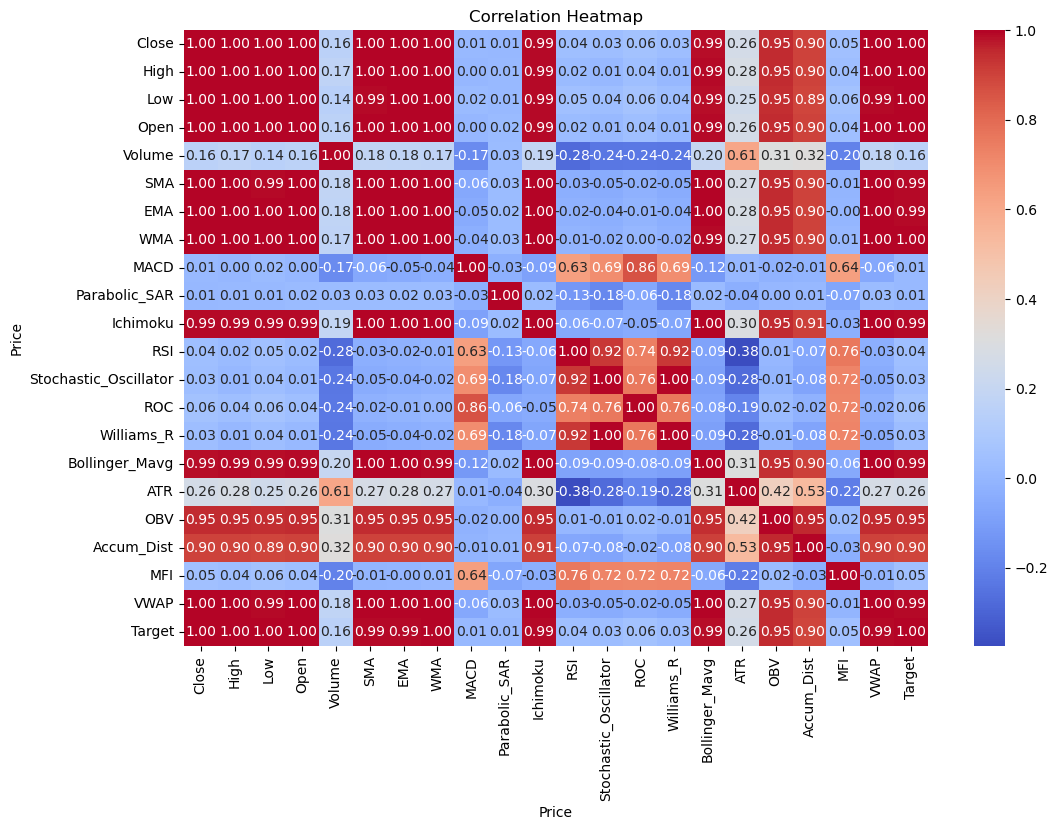

In [3]:
# =============================================================================
# Step 2: Correlation Heatmap
# =============================================================================
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

## Step 3: Feature Importances by Category (Separate Models)
- Utilizes an AdaBoost regressor to assess the importance of each technical indicator.

- Determines which indicators most significantly influence predictions.

- Selects a set of top indicators based on their feature importance scores for further analysis.

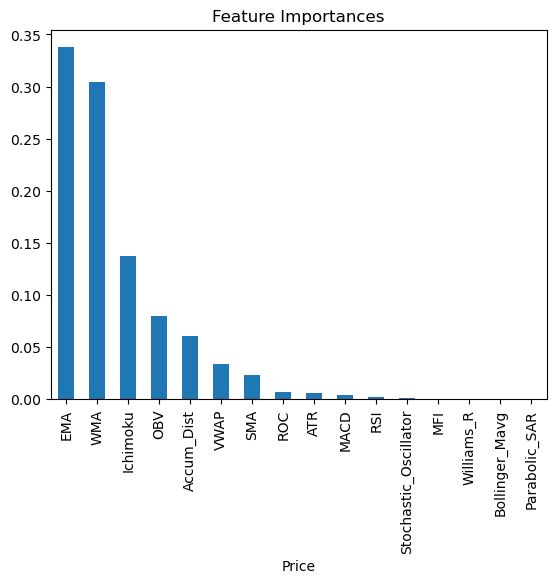

In [27]:
# =============================================================================
# Step 3: Feature Importance using AdaBoostRegressor
# =============================================================================
X = data.drop(columns=['Target', 'Close', 'Open', 'High', 'Low', 'Volume'])
y = data['Target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = AdaBoostRegressor(n_estimators=100, random_state=42)
model.fit(X_scaled, y)

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.plot(kind='bar', title='Feature Importances')
plt.show()

selected_features = importances.head(8).index

## Step 4: Evaluate Combinations of Selected Features (1-8 Indicators)
- Systematically tests all possible combinations (from 1 indicator up to 8 indicators) of the selected top indicators.

- Uses cross-validation (TimeSeriesSplit) to evaluate the predictive accuracy of each combination.

- Finds and highlights the combination of indicators that provides the best predictive performance.

In [28]:
# =============================================================================
# Step 4: Evaluate Combinations of Selected Indicators
# =============================================================================
ts_cv = TimeSeriesSplit(n_splits=5)
results_list = []

for r in range(1, len(selected_features) + 1):
    for combo in itertools.combinations(selected_features, r):
        X_combo = scaler.fit_transform(X[list(combo)])
        scores = cross_val_score(AdaBoostRegressor(random_state=42), X_combo, y, cv=ts_cv, scoring='neg_mean_squared_error')
        results_list.append({'features': combo, 'mean_neg_mse': scores.mean()})

results_df = pd.DataFrame(results_list).sort_values(by='mean_neg_mse', ascending=False)
best_combo = results_df.iloc[0]
print("Best Combination:", best_combo['features'])


Best Combination: ('WMA', 'OBV', 'VWAP', 'ROC')


## Step 5: Evaluate Combinations with Hyperparameter Optimization
- Takes the best-performing combination from step 4 and optimizes the AdaBoost model further through hyperparameter tuning.

- Uses GridSearchCV to search for the best number of estimators and learning rate.

- Splits data into 80% training and 20% testing sets for evaluation.

In [29]:
# =============================================================================
# Step 5: Hyperparameter Tuning with Best Combination
# =============================================================================
X_final = scaler.fit_transform(X[list(best_combo['features'])])
split_point = int(len(X_final) * 0.8)
X_train, X_test = X_final[:split_point], X_final[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

param_grid = {
    'n_estimators': [10, 30, 50, 100],  # Reduce number of weak learners
    'learning_rate': [0.001, 0.01, 0.05, 0.1],  # Lower learning rate for smoother learning
}


grid_search = GridSearchCV(AdaBoostRegressor(random_state=42), param_grid, cv=ts_cv, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)



Best Parameters: {'learning_rate': 0.1, 'n_estimators': 100}


| Parameter        | Baseline Model | Optimized Model |
|-----------------|---------------|----------------|
| `n_estimators`  | `50` (default) | `100` |
| `learning_rate` | `1.0` (default) | `0.1` |
| Features Used   | `Close Price` | `'WMA', 'OBV', 'VWAP', 'ROC'` |

## Step 6: Evaluate Final Model with Baseline and Overfitting Analysis
- Compares the final optimized AdaBoost model against a simple baseline model (predicting tomorrow's price using only today's price, no indicators).

- Evaluates model accuracy and robustness using metrics (R², MSE, MAE).

- Includes visualizations such as predicted vs. actual price plots, residual distribution, and learning curves to detect potential overfitting and evaluate generalization.

Baseline R2: 0.8495
Improved Model R2: 0.8022
Baseline RMSE: 106.7932
Improved Model RMSE: 123.4812
Baseline MSE: 11404.7953
Improved Model MSE: 15247.6102
Baseline MAE: 86.1659
Improved Model MAE: 97.3304
Baseline MAPE: 0.0212
Improved MAPE: 0.0241


c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\zulfa\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


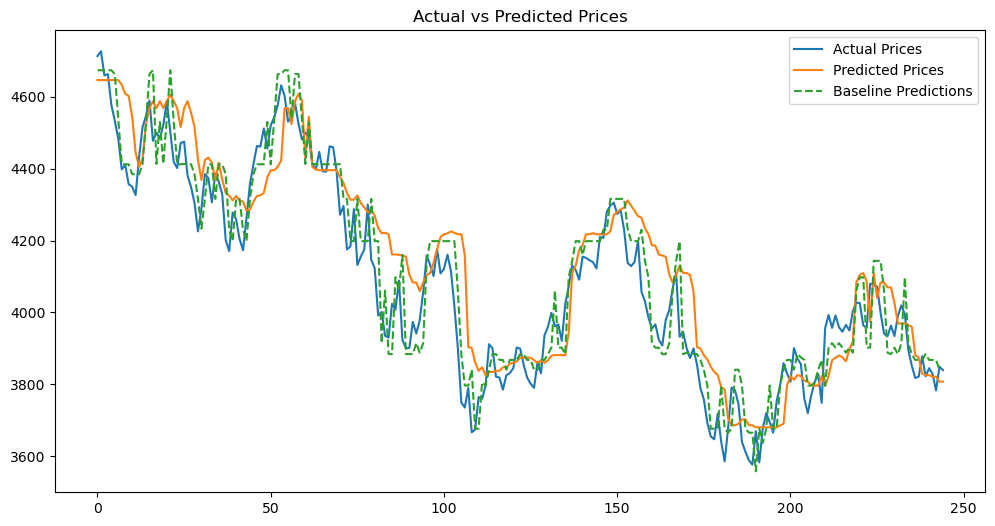

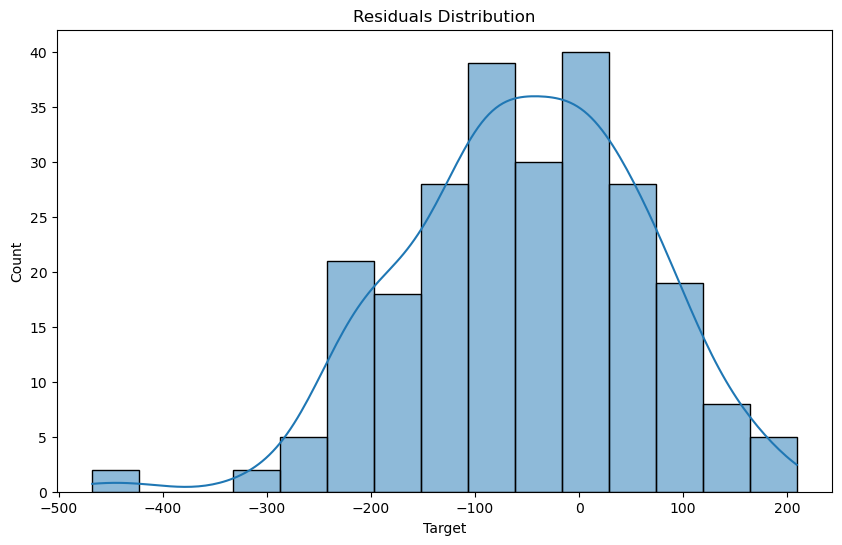

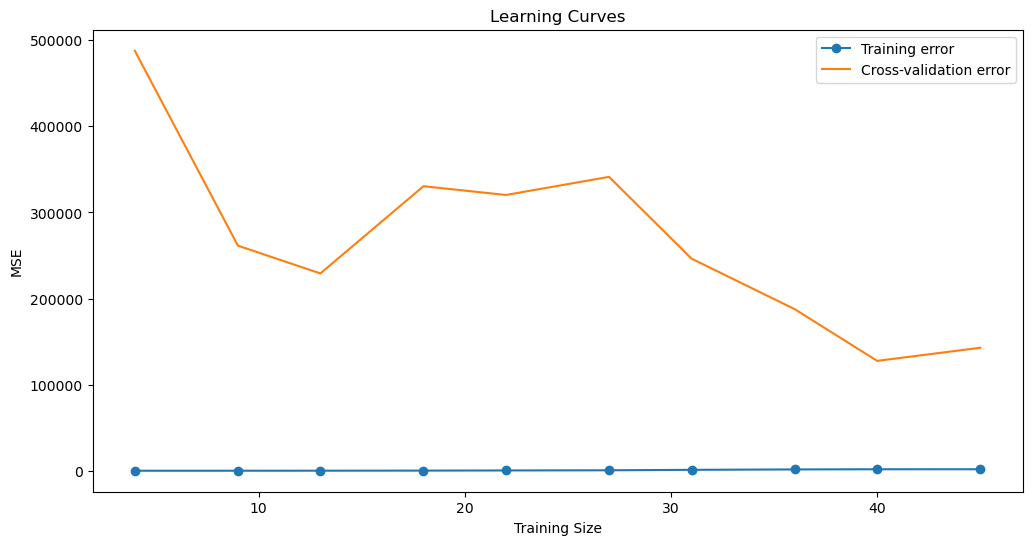

In [30]:
# Ensure no index misalignment
X_baseline = data[['Close']].shift(1)
y_baseline = data['Target']
valid_idx = X_baseline.dropna().index
X_baseline, y_baseline = X_baseline.loc[valid_idx], y_baseline.loc[valid_idx]

# Train-test split
Xb_train, Xb_test = X_baseline[:split_point], X_baseline[split_point:]
yb_train, yb_test = y_baseline[:split_point], y_baseline[split_point:]

# Train models
baseline_model = AdaBoostRegressor(random_state=42)
baseline_model.fit(Xb_train, yb_train)
yb_pred = baseline_model.predict(Xb_test)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluation Metrics
metrics = {
    "Baseline R2": r2_score(yb_test, yb_pred),
    "Improved Model R2": r2_score(y_test, y_pred),
    "Baseline RMSE": mean_squared_error(yb_test, yb_pred, squared=False),
    "Improved Model RMSE": mean_squared_error(y_test, y_pred, squared=False),
    "Baseline MSE": mean_squared_error(yb_test, yb_pred),
    "Improved Model MSE": mean_squared_error(y_test, y_pred),
    "Baseline MAE": mean_absolute_error(yb_test, yb_pred),
    "Improved Model MAE": mean_absolute_error(y_test, y_pred),
    "Baseline MAPE": mean_absolute_percentage_error(yb_test, yb_pred),
    "Improved MAPE": mean_absolute_percentage_error(y_test, y_pred),
}

for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

# Plot Actual vs. Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.to_numpy(), label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.plot(yb_pred, label='Baseline Predictions', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted Prices')
plt.show()

# Residual Analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_test, y_test, cv=ts_cv,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, -np.mean(train_scores, axis=1), 'o-', label='Training error')
plt.plot(train_sizes, -np.mean(test_scores, axis=1), label='Cross-validation error')
plt.title('Learning Curves')
plt.xlabel('Training Size')
plt.ylabel('MSE')
plt.legend()
plt.show()


## Conclusion
| Metric                        | Baseline Model | Improved AdaBoost Model |
|-------------------------------|---------------|-------------------------|
| R-squared (R²)                | 0.8495        | 0.8022                  |
| Mean Squared Error (MSE)       | 11,404.80     | 15,247.61               |
| Root Mean Squared Error (RMSE) | 106.79        | 123.48                  |
| Mean Absolute Error (MAE)      | 86.17         | 97.33                    |
| Mean Absolute Percentage Error (MAPE) | 2.12%   | 2.41%                   |


The baseline model (using only previous day's closing price) surprisingly outperforms your AdaBoost model in all presented metrics (lower MAE, RMSE, and MSE; higher R²). This indicates that the indicators used might introduce unnecessary complexity or noise, thereby reducing prediction accuracy.

<b>Insights from Charts:<b>

### Actual vs Predicted Prices:
- The AdaBoost predictions generally follow the trends but are not consistently closer to actual prices compared to the baseline.
- The baseline model is simpler yet consistently outperforms, suggesting the complexity added by technical indicators is not currently benefiting your prediction significantly.

### Residual Distribution:
- Residuals are roughly symmetrical but show slight skewness and variance.
- This indicates some inconsistencies and occasional prediction errors, highlighting room for improvement.

### Learning Curve:
- There's a large gap between training and cross-validation errors (training error extremely low, validation error high), strongly indicating overfitting.
- The model performs exceptionally on training data (memorizing), but generalization to new data is poor.